In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]

In [2]:
# get univariate statistics
youtube_df.describe()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
count,5000.000000,5000.00,5.000000e+03,5000.000000,5000.00,5.000000e+03
mean,3859.466797,2620021.50,1.071449e+09,1288.413818,2081598.25,7.828476e+08
std,17075.607422,3771402.25,2.003844e+09,1779.179321,1781480.25,7.754301e+08
min,1.000000,301.00,7.500000e+01,1.000000,301.00,7.500000e+01
25%,141.000000,666802.50,1.862329e+08,141.000000,666802.50,1.862329e+08
50%,445.000000,1544402.00,4.820548e+08,445.000000,1544402.00,4.820548e+08
75%,1511.500000,2723181.50,1.124368e+09,1511.500000,2723181.50,1.124368e+09
max,422326.000000,65995312.00,4.754884e+10,5653.000000,5895361.00,2.468241e+09


In [4]:
youtube_df.describe(include='O')

,Rank,Grade,Channel name
count,5000,5000,5000
unique,5000,5,4993
top,"1,053rd",B+,Bollywood Classics
freq,1,2960,2


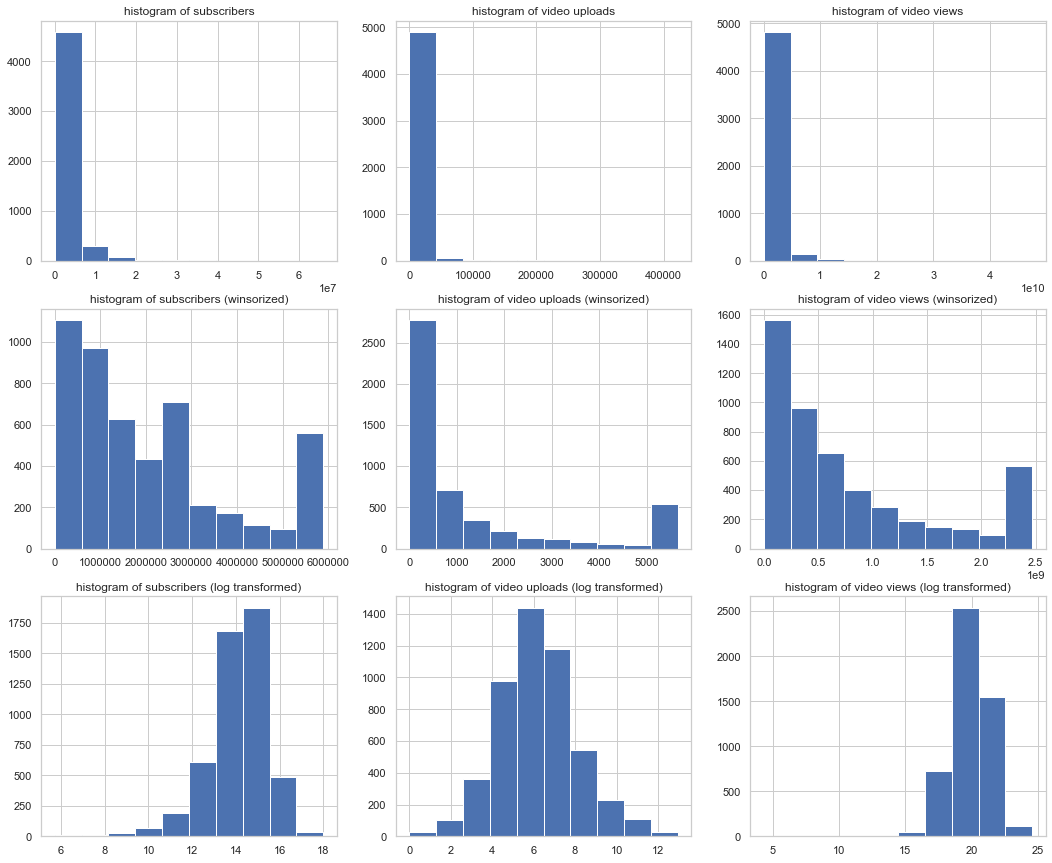

In [5]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(youtube_df["Subscribers"])
plt.title("histogram of subscribers")

plt.subplot(3, 3, 2)
plt.hist(youtube_df["Video Uploads"])
plt.title("histogram of video uploads")

plt.subplot(3, 3, 3)
plt.hist(youtube_df["Video views"])
plt.title("histogram of video views")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("histogram of subscribers (winsorized)")

plt.subplot(3, 3, 5)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("histogram of video uploads (winsorized)")

plt.subplot(3, 3, 6)
plt.hist(youtube_df["winsorized_views"])
plt.title("histogram of video views (winsorized)")

# histograms of the log transformed data
plt.subplot(3, 3, 7)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("histogram of subscribers (log transformed)")

plt.subplot(3, 3, 8)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("histogram of video uploads (log transformed)")

plt.subplot(3, 3, 9)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("histogram of video views (log transformed)")


plt.show()

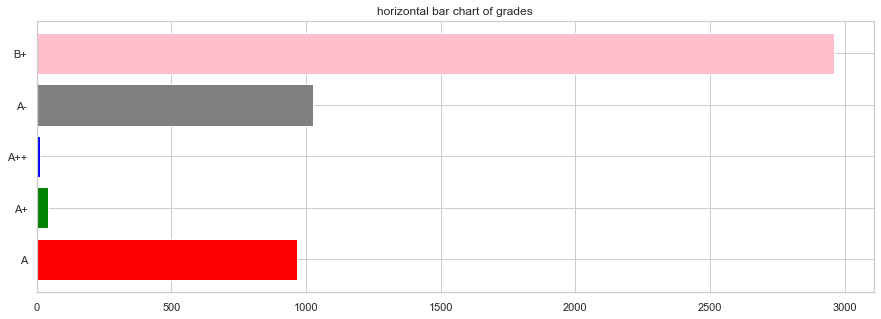

In [6]:
# bar chart of grades
plt.figure(figsize=(15,5))
plt.barh(youtube_df.groupby("Grade")["Grade"].count().index, 
        youtube_df.groupby("Grade")["Grade"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of grades")

plt.show()

In [8]:
pip install wordcloud

     |████████████████████████████████| 161 kB 1.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


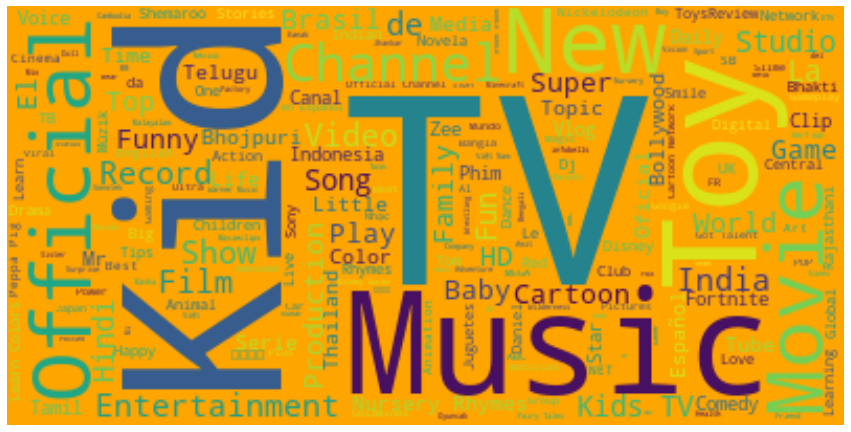

In [11]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="orange").generate(" ".join(youtube_df["Channel name"]))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()